In [ ]:
# General packages
import numpy as np
from numpy.random import default_rng
import scipy as sp
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline
import csv
import time

# Tracking code

# ML border recognition
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Only needed for animations:
import matplotlib.animation as anim
from matplotlib import rc
rc('animation', html='jshtml')

# Only needed to get a progress bar
from tqdm import tqdm

We will study two general cases of Dynamic Aperture: with two-dimensional initial conditions (sampled in $x$ and $y$, with $p_x=0$ and $p_y=0$), and with four-dimensional initial conditions (sampled in $x$, $p_x$, $y$, and $p_y$)

First we create a coarse setup of initial conditions (a limited number of  points):

Next we create an object that represents the ML classification:

In [ ]:
svc = SVC(kernel="rbf") 

# We rescale the input automatically to have a more universal approach
svc_pipe = make_pipeline(StandardScaler(), svc)

# TODO: if the ML model reaches the border of the parameter space -> expand the latter
svc_param_grid = {
                'svc__C': 10**np.linspace(-2, 4, 31),
                'svc__gamma': 10**np.linspace(-1, 2, 11),
                'svc__decision_function_shape': ['ovr','ovo']
             }
grid_svc = GridSearchCV(svc_pipe, svc_param_grid, verbose=1)

In [ ]:
clf = grid_svc
clf.fit(input_data, true_labels)

print(clf.best_params_)

Fitting 5 folds for each of 682 candidates, totalling 3410 fits
{'svc__C': 630.9573444801943, 'svc__decision_function_shape': 'ovr', 'svc__gamma': 1.5848931924611134}


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix  
grid_predictions = clf.predict(input_data)
print(confusion_matrix(true_labels,grid_predictions))
print(classification_report(true_labels,grid_predictions))

[[274   3]
 [  3 262]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       277
         1.0       0.99      0.99      0.99       265

    accuracy                           0.99       542
   macro avg       0.99      0.99      0.99       542
weighted avg       0.99      0.99      0.99       542



Now the logic is the following: we will use the classifier to create a grid of points which we then classify with the ML classifier. We make a contourplot of these categories, and retrieve the path of the contour. Finally we create an interpolated spline of this contour that will be our border curve.

So, first we create the grid:

In [ ]:
grid_step=0.1

x_min = -2
x_max = 2
y_min = -2
y_max = 2

xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),np.arange(y_min, y_max, grid_step))

Then we classify these points with the predictor:

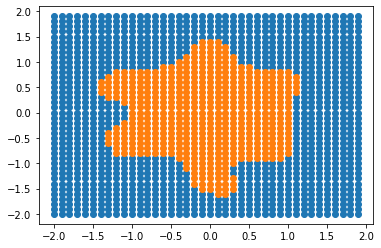

In [ ]:
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.scatter(xx[np.where(Z==0)],yy[np.where(Z==0)])
plt.scatter(xx[np.where(Z==1)],yy[np.where(Z==1)])

We can always improve the accuracy by refining the grid:

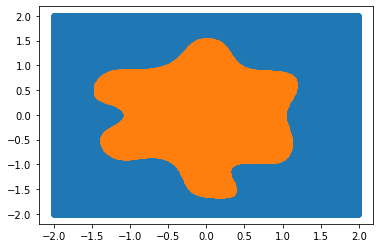

In [ ]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),np.arange(y_min, y_max, 0.01))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.scatter(xx[np.where(Z==0)],yy[np.where(Z==0)])
plt.scatter(xx[np.where(Z==1)],yy[np.where(Z==1)])

N.B. We can make this more efficient by iteratively refining the grid: first do the previous for a 0.1 grid, then get the border function as below, then use this to sample a new grid around the border function and calculate the contour anew (with `tricontourf` as the grid won't be rectangular anymore).

So then we plot these classified points in a contourplot, and use the vertices of the contour as input to be interpolated.

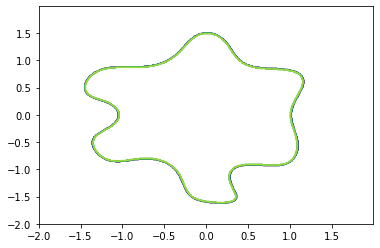

In [ ]:
contour_min_turns = plt.contour(xx, yy, Z)
path_min_turns    = contour_min_turns.collections[0].get_paths()[0]
v_min_turns       = path_min_turns.vertices

In [ ]:
contour =  np.array(v_min_turns)

In [ ]:
contour = np.float32(contour)

In [ ]:
import cv2 as cv
area = cv.contourArea(contour)
print(area)

4.918500015322126


The points we are interested in are in `v_min_turns`, so we interpolate these:

In [ ]:
x_min_turns = v_min_turns[:,0]
y_min_turns = v_min_turns[:,1]
min_border_data = np.vstack((x_min_turns, y_min_turns))

min_border, u = sp.interpolate.splprep(min_border_data, s=0, per=1)

The interpolated curve is in `min_border`. So let's test to see how the curve looks like:

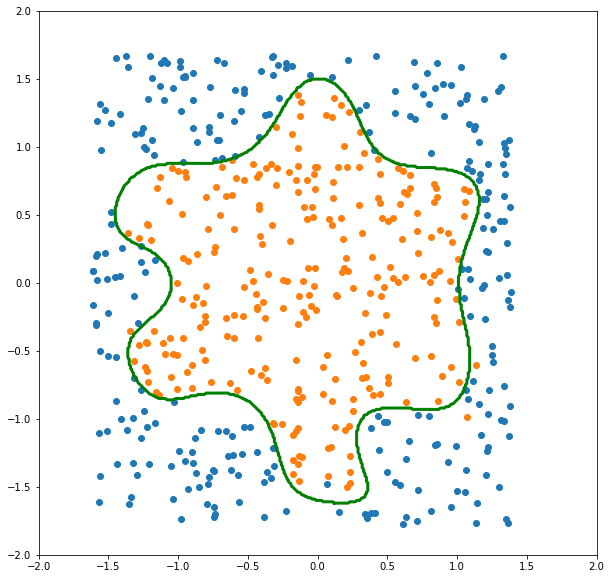

In [ ]:
u_new = np.linspace(0, 1, 1000)
x_new, y_new = sp.interpolate.splev(u_new, min_border)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(input_data[np.where(true_labels != 1)][:,0], input_data[np.where(true_labels  != 1)][:,1])
ax.scatter(input_data[np.where(true_labels == 1)][:,0], input_data[np.where(true_labels == 1)][:,1])

ax.plot(x_new, y_new, 'g-',linewidth=3)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
plt.show()

#### Maximum border

Let's now try to put all border detection into one function:

In [ ]:
def get_border_curve(DA, Nturn, step_resolution=0.01):
    true_labels = np.zeros(np.array(DA[2]).shape)
    true_labels[np.where(DA[2]>=Nturn)] = 1
    true_labels[np.where(DA[2]<Nturn)] = 0

    data = DA[:2].T
    region = data[np.where(true_labels == 1)].T
    xmin, xmax = region[0].min(), region[0].max()
    ymin, ymax = region[1].min(), region[1].max()
    x_margin = 0.1*(xmax - xmin)
    y_margin = 0.1*(ymax - ymin)

    mask = np.array([ xmin-x_margin <= x <= xmax+x_margin and ymin-y_margin <= y <= ymax+y_margin for x,y in data])
    input_data = data[mask]
    true_labels = true_labels[mask]
    
    clf = grid_svc
    clf.fit(input_data, true_labels)
    print(clf.best_params_)
    
    # TODO: This whole hack to find the curve by using contour plot is not ideal.
    # We should look for smarter alternatives, or at least do the step_resolution iteratively
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_resolution),np.arange(y_min, y_max, step_resolution))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    contour = plt.contour(xx, yy, Z)
    path = contour.collections[0].get_paths()[0]
    vert = path.vertices
    border_data = np.vstack((vert[:,0], vert[:,1]))

    border, u = sp.interpolate.splprep(border_data, s=0, per=1)
    return border

Let's try our function to find the maximum border curve:

Fitting 5 folds for each of 682 candidates, totalling 3410 fits
{'svc__C': 100.0, 'svc__decision_function_shape': 'ovr', 'svc__gamma': 0.3981071705534972}


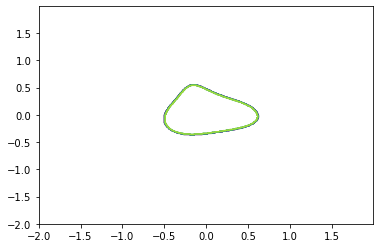

In [ ]:
max_border = get_border_curve(DA,max_turns)

The interpolated curve is in `max_border`. So let's test to see how the curve looks like:

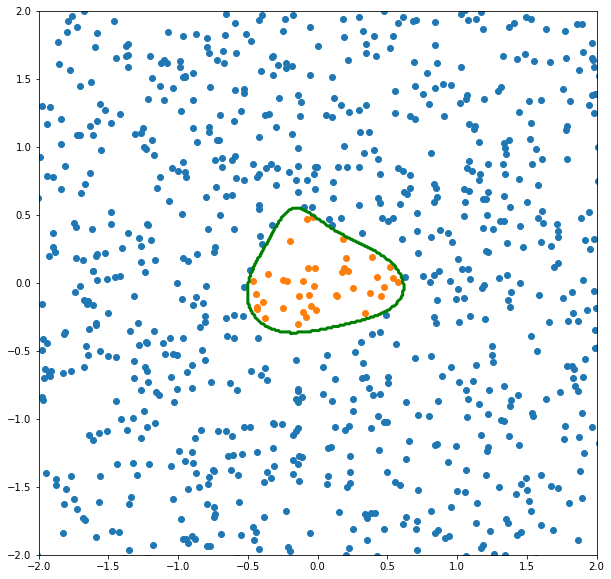

In [ ]:
u_new = np.linspace(0, 1, 1000)
x_new, y_new = sp.interpolate.splev(u_new, max_border)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(DA[0][true_labels_max_turns==0], DA[1][true_labels_max_turns==0])
ax.scatter(DA[0][true_labels_max_turns==1], DA[1][true_labels_max_turns==1])

ax.plot(x_new, y_new, 'g-',linewidth=3)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
plt.show()

#### Syncing both curves

Our previous efforts indeed create two nicely interpolated splines:

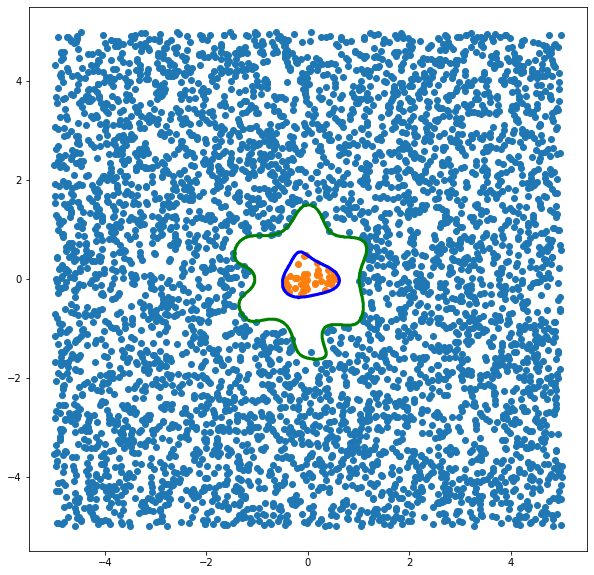

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(DA[0][true_labels_min_turns==0], DA[1][true_labels_min_turns==0])
ax.scatter(DA[0][true_labels_max_turns==1], DA[1][true_labels_max_turns==1])

u_new = np.linspace(0, 1, 1000)
x_new, y_new = sp.interpolate.splev(u_new, min_border)
ax.plot(x_new, y_new, 'g-', linewidth=3)

u_new = np.linspace(0, 1, 1000)
x_new, y_new = sp.interpolate.splev(u_new, max_border)
ax.plot(x_new, y_new, 'b-', linewidth=3)
plt.show()

Now this has a problem, namely that the curves' parameters do not start at roughly the same position. We can demonstrate this by animating the distance between the two curves for the same parameter:

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2))
line, = ax.plot([], [], 'ro-')
u_new = np.linspace(0, 1, 1000)
x_new, y_new = sp.interpolate.splev(u_new, min_border)
plt.plot(x_new, y_new, 'b-')
x_new, y_new = sp.interpolate.splev(u_new, max_border)
plt.plot(x_new, y_new, 'b-')

nframes = 100
# initialization function: plot the background of each frame
u_new = np.linspace(0, 1, 1000)
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    u = i/nframes
    tes=np.array([sp.interpolate.splev(u, min_border),sp.interpolate.splev(u, max_border)]).T
    line.set_data(tes[0], tes[1])
    return line,

anim.FuncAnimation(fig, animate, init_func=init,
                               frames=nframes, interval=20, blit=True)

As you can see, the inner curve is a bit 'behind' the outer curve.
Now, we want to make sure both curves start at roughly the same position for $u=0$ (such that they loop as closely as possible when sampling). For this, we keep the starting value for $u$ at 0 for the outer curve, but let the inner curve start at the position which is closest to the starting position of the outer curve:

In [ ]:
def getDistance(u_min_border,u_max_border):
    points_min = np.array(sp.interpolate.splev(u_min_border, min_border))
    points_max = np.array(sp.interpolate.splev(u_max_border, max_border))
    return np.linalg.norm( points_max - points_min, axis=0)

ustart_min_border = np.mod(
    sp.optimize.minimize_scalar(lambda u : getDistance(u,0)
                                , bounds=[0,1e6], method='bounded')['x']
    ,1)

In [ ]:
ustart_min_border

0.005707766310033557

And indeed, by letting the outer curve start at `ustart_min_border` the distance in more in sync:

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2))
line, = ax.plot([], [], 'ro-')
u_new = np.linspace(0, 1, 1000)
x_new, y_new = sp.interpolate.splev(np.mod(u_new + ustart_min_border,1), min_border)
plt.plot(x_new, y_new, 'b-')
x_new, y_new = sp.interpolate.splev(u_new, max_border)
plt.plot(x_new, y_new, 'b-')

nframes = 100
# initialization function: plot the background of each frame
u_new = np.linspace(0, 1, 1000)
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    u = i/nframes
    tes=np.array([
        sp.interpolate.splev(np.mod(u + ustart_min_border,1), min_border),
        sp.interpolate.splev(u, max_border)
    ]).T
    line.set_data(tes[0], tes[1])
    return line,

anim.FuncAnimation(fig, animate, init_func=init,
                               frames=nframes, interval=20, blit=True)

### Sampling

Now that we defined the border functions, we can start to refine the sampling.

For this, we sample $u$ uniformly from [0,1] to define on which line segment it falls, and then multiply this with another distribution to define where on that line it falls. For the latter we will use a Raleigh distribution with its peak close to the inner border function and its tail close to the outer border function (because in practice $N_\text{turns}$ goes down rather steeply so we want more particles sampled there). This could be replaced by an adaptive algorithm that populates the high-$N_\text{turns}$ regions more (TODO later).

In other words, the final point will have coordinates:

$a(u) + \big(b(u)-a(u)\big)\frac{R-0.4}{2}$, where $a(u)$ and $b(u)$ are the points on the inner resp. outer curve for a given sampled $u$, and $R$ is a Raleigh random variable.


Let's test it by sampling an additional 5000 points,and visualise them:

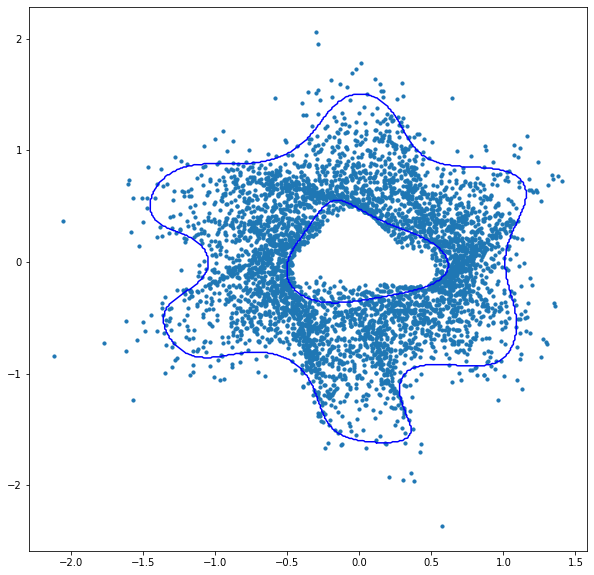

In [ ]:
n_samples=5000
rng = default_rng()
u = rng.uniform(low=0,high=1,size=n_samples)
R = rng.rayleigh(scale=1,size=n_samples)

ax,ay = sp.interpolate.splev(u, max_border)
bx,by = sp.interpolate.splev(np.mod(u + ustart_min_border,1), min_border)
x_refined = ax + (bx-ax)*(R-0.4)/2
y_refined = ay + (by-ay)*(R-0.4)/2

plt.figure(figsize=(10,10))
u_new = np.linspace(0, 1, 1000)
x_new, y_new = sp.interpolate.splev(u_new, min_border)
plt.plot(x_new, y_new, 'b-')
x_new, y_new = sp.interpolate.splev(u_new, max_border)
plt.plot(x_new, y_new, 'b-')
plt.scatter(x_refined, y_refined,s=10)
plt.show()

## Refined Tracking

Let's track some additional sampled points:

In [ ]:
n_samples=50000
rng = default_rng()
u = rng.uniform(low=0,high=1,size=n_samples)
R = rng.rayleigh(scale=1,size=n_samples)

ax,ay = sp.interpolate.splev(u, max_border)
bx,by = sp.interpolate.splev(np.mod(u + ustart_min_border,1), min_border)
x_refined = ax + (bx-ax)*(R-0.4)/2
y_refined = ay + (by-ay)*(R-0.4)/2

In [ ]:
#np.savetxt("input2D_refined.csv", np.array([x_refined,y_refined]), delimiter=",")
[x_refined,y_refined] = np.genfromtxt('input2D_refined.csv', delimiter=',')

In [ ]:
engine = hm.partial_track.generate_instance(x_refined, np.zeros_like(x_refined), y_refined, np.zeros_like(y_refined))
engine

In [ ]:
n_turns = 1e7

t_start = time.time()
engine.reset()

# the tracking happens in engine.compute()
for i in tqdm(range(int(n_turns/1000)-1)):
    engine.compute(1000, 0.0)
DA_refined = np.array([
    np.array([*DA[0],*x_refined]),
    np.array([*DA[1],*y_refined]),
    np.array([*DA[2],*engine.compute(1000, 0.0)[4]])
])

t_end = time.time()
print(f"Tracking time was: {t_end - t_start:.2f} seconds")

100%|██████████| 9999/9999 [06:43<00:00, 24.77it/s]

Tracking time was: 403.81 seconds


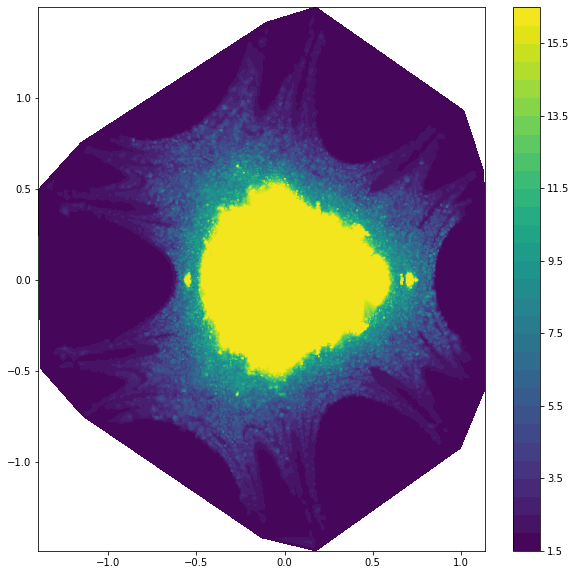

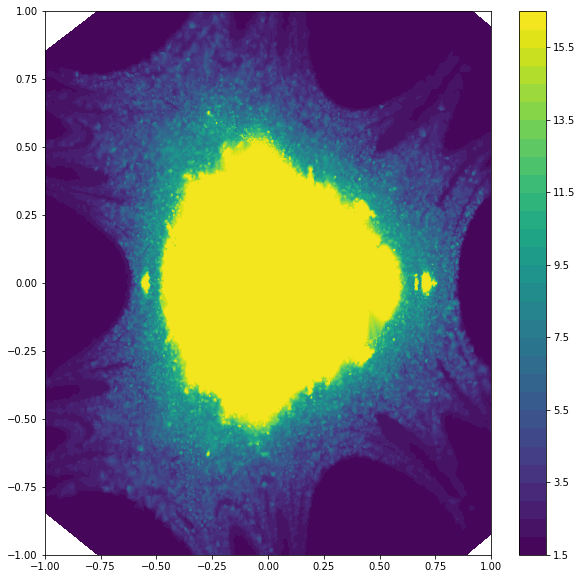

In [ ]:
plt.figure(figsize=(10,10))
mask = [ x>min_turns for x in DA_refined[2] ]
plt.tricontourf(DA_refined[0][mask], DA_refined[1][mask], np.log(DA_refined[2][mask]), levels=30,cmap='viridis')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
mask = [ x>min_turns for x in DA_refined[2] ]
plt.tricontourf(DA_refined[0][mask], DA_refined[1][mask], np.log(DA_refined[2][mask]), levels=30,cmap='viridis')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.colorbar()
plt.show()

## NEXT STEP (ELENA): Recognise borders for each $N_\text{turns}$ and calculate volume

## TODO later: ADAPTIVE SAMPLING that samples most particles in the region where $N_\text{turns}$ falls down most rapidly

# 4D  (NOT STARTED YET)

## Random Input

In [ ]:
n_samples = 1000000
x = np.random.uniform(low=-1,high=1,size=n_samples)
px = np.random.uniform(low=-1,high=1,size=n_samples)
y = np.random.uniform(low=-1,high=1,size=n_samples)
py = np.random.uniform(low=-1,high=1,size=n_samples)

In [ ]:
engine = hm.partial_track.generate_instance(x,px,y,py)
engine.reset()
engine

In [ ]:
data = engine.compute(100000, 0.0)

In [ ]:
final=np.array([x,px,y,py,data[4]])

In [ ]:
final[:, final[4]>100]

array([[ 3.58820200e-01, -3.77863024e-01, -2.08645745e-01, ...,
        -8.12223997e-02,  2.50888936e-01,  6.15645419e-01],
       [-4.83358048e-01, -5.16621255e-01,  2.26613736e-01, ...,
        -2.34576532e-01, -5.17694202e-01, -2.35496714e-01],
       [-9.26577960e-02,  1.28910633e-01,  6.15537978e-01, ...,
        -2.89863680e-01, -4.43596681e-01, -2.36017418e-01],
       [-3.88483971e-01, -2.11832615e-01,  2.44998603e-03, ...,
        -1.68992291e-01, -2.04596616e-01, -7.85067363e-02],
       [ 1.05900000e+03,  4.60000000e+02,  3.79000000e+02, ...,
         1.00000000e+05,  1.48000000e+02,  1.03730000e+04]])

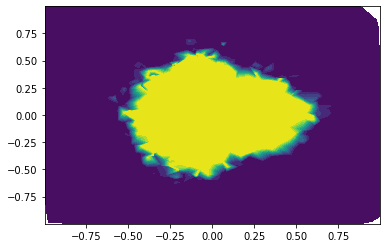

RuntimeError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure()

px_s = 0
py_s = 0
w = 0.05

mask = [ abs(px-px_s)<w and abs(py-py_s)<w for (x,px,y,py,n) in final.transpose() ]

plt.tricontourf(x[mask], y[mask], data[4][mask], levels=15,cmap='viridis')

plt.show()
plt.colorbar()

In [ ]:
len(x[mask])

In [ ]:
plt.figure()

px_s = 0
py_s = 0
w = 0.05

mask = [ abs(px-px_s)<w and abs(py-py_s)<w for (x,px,y,py,n) in final.transpose() ]

plt.scatter(x[mask], y[mask], c=data[4][mask], cmap='viridis')

plt.show()
plt.colorbar()